# Identify specific populations and expand these masks - multiobject

Building on the principles of single-object analysis, this approach can be extended to simultaneously explore multiple objects.

While single-object analysis can be repeated for different object types, it does not account for spatial overlaps or interactions between them—highlighting the need for a simultaneous, multi-object approach. 

The multiclass object analysis resolves this by generating Voronoi diagrams, which constrain expansions to areas closer to one object type than to any other. This ensures that regions around object type A are strictly associated with A and not influenced by proximity to object type B. 

We exemplify this approach using the previously defined γδ contours along with contours identifying CD8+ T cell regions. CD8+ T cell regions were defined using a kernel size of 5.5 µm to identify areas containing at least two transcripts of CD8, TRAC, and TRBC. These regions were further filtered to include only those with at least one CD8, one TRAC, and one TRBC, where the combined TRAC and TRBC counts exceeded those of TRDC and TRGC, and CD8 transcript levels were higher than CD4.   

To demonstrate the utility of this approach, we performed differential gene expression analysis between areas surrounding γδ T cell and CD8⁺ T cell regions, revealing distinct transcriptomic profiles in their respective microenvironments. 

In [39]:
%load_ext autoreload

import os 
import sys
import time
import logging
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json

from natsort import natsorted
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from PIL import Image, ImageDraw
import json
import math
import matplotlib.patches as mpatches
import matplotlib.patches as patches
from skimage.measure import label
import anndata as ad
import seaborn as sns
import scanpy as sc

sys.path.append(os.path.dirname(os.getcwd()))
from gridgene import get_arrays as ga
from gridgene import contours, get_masks 
from gridgene.mask_properties import MaskAnalysisPipeline, MaskDefinition
from gridgene.get_masks import MultiClassObjectAnalysis

from helper_plot import plot_TRGC_TRDC_points_polygons, plot_TRGC_TRDC_points_contours, plot_TRGC_TRDC_points_mask

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


define looger -- important to save info of the runs 

In [2]:
# define the logger :  can be None, and is set to INFO
# Custom logger setup
logger = logging.getLogger('contour_logger')
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

define files

In [3]:
cosmx_path_s3 =  '../../cosmx_data/S3/S3/20230628_151317_S3/AnalysisResults/yxyz3r7ufm'

folder_names_s3 = [folder_name for folder_name in os.listdir(cosmx_path_s3) if
                os.path.isdir(os.path.join(cosmx_path_s3, folder_name))]


target_files_s3 = [
    os.path.join(cosmx_path_s3, folder, file)
    for folder in os.listdir(cosmx_path_s3)
    if os.path.isdir(os.path.join(cosmx_path_s3, folder))
    for file in os.listdir(os.path.join(cosmx_path_s3, folder))
    if '__target_call_coord.csv' in file
]

files_cosmx = natsorted(target_files_s3)
len(files_cosmx)

dapi_folder = '/home/martinha/PycharmProjects/phd/spatial_transcriptomics/cosmx_data/S3/S3/20230628_151317_S3/CellStatsDir/Morphology2D/'
annotation_cellpose = '/home/martinha/PycharmProjects/phd/spatial_transcriptomics/cosmx_data/S3/Slide4_S3_CosMx_CellPose_All_annotated.csv'


annotation_df = pd.read_csv(annotation_cellpose)
print(annotation_df['Final_label'].value_counts())
print(len(annotation_df))

Final_label
Epithelial cells     20558
T cells               9436
Myeloid cells         6688
Fibroblasts           6133
Other cells           4988
Plasma cells          1656
Endothelial cells     1508
Name: count, dtype: int64
50967


***2. Define GD***

This intends to, based on defined genes, find γδ T cells.

We need to define: 

1. Parameters for γδ contours
    * Genes to consider
    * density
    * minimum area
    * kernel size
    
    this will define for an overlapping area with **kernel size** a minimum number of **density** **genes of interest**. The contiguous area of the contour will have at least **minimum area**. 
 
2. You may also need to define extra parameters to filter out wrong contours   

Define arrays for an example FOV

In [4]:
target_gd = ['TRGC1/TRGC2', 'TRDC']
target_ab = ['TRBC1/TRBC2', 'TRAC']

target_cd8 = ['CD8A','CD8B', 'TRBC1/TRBC2', 'TRAC']
target_cd4 = ['CD4']

target_tum = ['EPCAM', 'CEACAM6', 'CLDN4', 'CDH1', 'RNF43', 'SPINK1', 'SOX9', 'CD24', 'KRT19', 'AREG',
              'REG1A', 'AGR2', 'PLAC8', 'CALB1', 'S100P', 'ITGA6', 'DMBT1', 'DUSP4',
              'KRT8', 'S100A6', 'RPL37', 'RPL32', 'KRT18', 'OLFM4',
              'PRSS2', 'CD55', 'EPHB4', 'ADGRL1', 'KRT17', 'ITGB8', 'ADGRE5', 'GDF15', 'IL27RA', 'AZGP1'
              ]  # cadherin 'PIGR',  'LYZ','SERPINA1'

T cells are usually between 5-10 um diameter, in CosMx this will be between 43 px and 85 px. 
We will find regions possible with γδ using the convolution approach.

In [5]:
density_th_gd = 2
min_area_th_gd = 5  # 40
kernel_size_gd = 45 #90 

***Multi class Object analysis - CD8+ and γδ***

Following the same principles outlined in the single-object analysis, it is also possible to extend the approach to explore multiple object types simultaneously. While running the single-object analysis multiple times could achieve this, it does not account for overlapping areas between different object types. The multiclass object analysis resolves this by generating Voronoi diagrams, which constrain expansions to areas closer to one object type than to any other. This ensures that regions around object type A are strictly associated with A and not influenced by proximity to object type B.

We exemplify this approach using the previously defined γδ contours along with contours identifying CD8+ T-cell regions.

CD8+ T-cell regions were defined using a kernel size of 5.5 µm to identify areas containing more than two transcripts of CD8, TRAC, and TRBC. These regions were further filtered to ensure they contained more TRAC+TRBC transcripts than TRGC+TRDC transcripts, with at least one count of each transcript present.

The analysis includes differential gene expression profiling between areas surrounding γδ T cell and CD8+ T  cell regions, highlighting distinct transcriptomic patterns in their respective vicinities. 


define γδ contours

In [40]:
fov = 'FOV007'
file_csv = [file for file in files_cosmx if fov in file][0]  
    
df_total = pd.read_csv(file_csv)
df_total = df_total.rename(columns={'x': 'X', 'y': 'Y'})
df_total = df_total[~df_total['target'].str.contains('System|egative')]

n_genes = len(df_total['target'].unique())
height = int(max(df_total['X'])) + 1
width = int(max(df_total['Y'])) + 1

print(f'n genes: {n_genes}')
print(f'shape: {height}, {width}')
print(f'n hits {len(df_total)}')

target_dict_total = {target: index for index, target in enumerate(df_total['target'].unique())}
array_total = ga.transform_df_to_array(df = df_total, target_dict=target_dict_total, array_shape = (height, width,len(target_dict_total))).astype(np.int8)

# creating subsets 
df_subset_gd, array_subset_gd, target_indices_subset_gd = ga.get_subset_arrays(df_total, array_total,
                                                                                   target_dict_total,
                                                                                   target_list=target_gd,
                                                                           target_col='target')

df_subset_ab, array_subset_ab, target_indices_subset_ab = ga.get_subset_arrays(df_total, array_total,
                                                                                       target_dict_total,
                                                                                       target_list=target_ab,
                                                                                       target_col='target')
    
    
df_subset_g, array_subset_g, target_indices_subset_g = ga.get_subset_arrays(df_total, array_total,
                                                                                       target_dict_total,
                                                                                       target_list=['TRGC1/TRGC2'],
                                                                                       target_col='target')
    
df_subset_d, array_subset_d, target_indices_subset_d = ga.get_subset_arrays(df_total, array_total,
                                                                                       target_dict_total,
                                                                                       target_list=['TRDC'],
                                                                                       target_col='target')


df_subset_tum, array_subset_tum, target_indices_subset_tum = ga.get_subset_arrays(df_total, array_total,target_dict_total,
                                                                         target_list=target_tum, target_col = 'target')


df_subset_cd8, array_subset_cd8, target_indices_subset_cd8 = ga.get_subset_arrays(df_total, array_total,
                                                                                      target_dict_total,
                                                                                      target_list=target_cd8,
                                                                                      target_col='target')
                                                                               

df_subset_TRAC_gene, array_subset_TRAC_gene, target_indices_subset_TRAC_gene = ga.get_subset_arrays(df_total, 
                                                                                                 array_total,
                                                                                      target_dict_total,
                                                                                      target_list= ['TRAC'],
                                                                                      target_col='target')

df_subset_TRBC_gene, array_subset_TRBC_gene, target_indices_subset_TRBC_gene = ga.get_subset_arrays(df_total, 
                                                                                                 array_total,
                                                                                      target_dict_total,
                                                                                      target_list= ['TRBC1/TRBC2'],
                                                                                      target_col='target')


df_subset_cd8_gene, array_subset_cd8_gene, target_indices_subset_cd8_gene = ga.get_subset_arrays(df_total, 
                                                                                                 array_total,
                                                                                      target_dict_total,
                                                                                      target_list= ['CD8A', 'CD8B'],
                                                                                      target_col='target')

df_subset_cd4_gene, array_subset_cd4_gene, target_indices_subset_cd4_gene = ga.get_subset_arrays(df_total, 
                                                                                                 array_total,
                                                                                      target_dict_total,
                                                                                      target_list= ['CD4'],
                                                                                      target_col='target')

CGD = contours.ConvolutionContours(array_subset_gd, contour_name='GD', logger=logger)
CGD.get_conv_sum(kernel_size=kernel_size_gd, kernel_shape='square')  #
CGD.contours_from_sum(density_threshold=density_th_gd,
                      min_area_threshold=min_area_th_gd, directionality='higher')

### Filtering 
CGD.filter_contours_by_gene_comparison(gene_array1 = array_subset_gd, gene_array2 = array_subset_ab,
                                       gene_name1 = "gd", gene_name2 = "ab") # gene 1 > gene2 --> valid contour 
# G>0 D>0
CGD.filter_contours_by_gene_threshold(gene_array = array_subset_d.squeeze(), threshold = 1, gene_name = 'TRDC')# >= 1
CGD.filter_contours_by_gene_threshold(gene_array = np.sum(array_subset_g, axis=-1), threshold = 1, gene_name = 'TRGC1_2')# >= 1

n genes: 999
shape: 4246, 4245
n hits 2838781
get_conv_sum took 0.4297 seconds
contours_from_sum took 0.2267 seconds


***contours CD8***

In [8]:
density_th_cd8 = 2
min_area_th_cd8 = 5
kernel_size_cd8 = 45 # 40

get_conv_sum took 0.4386 seconds
contours_from_sum took 0.2458 seconds
total contours found  22


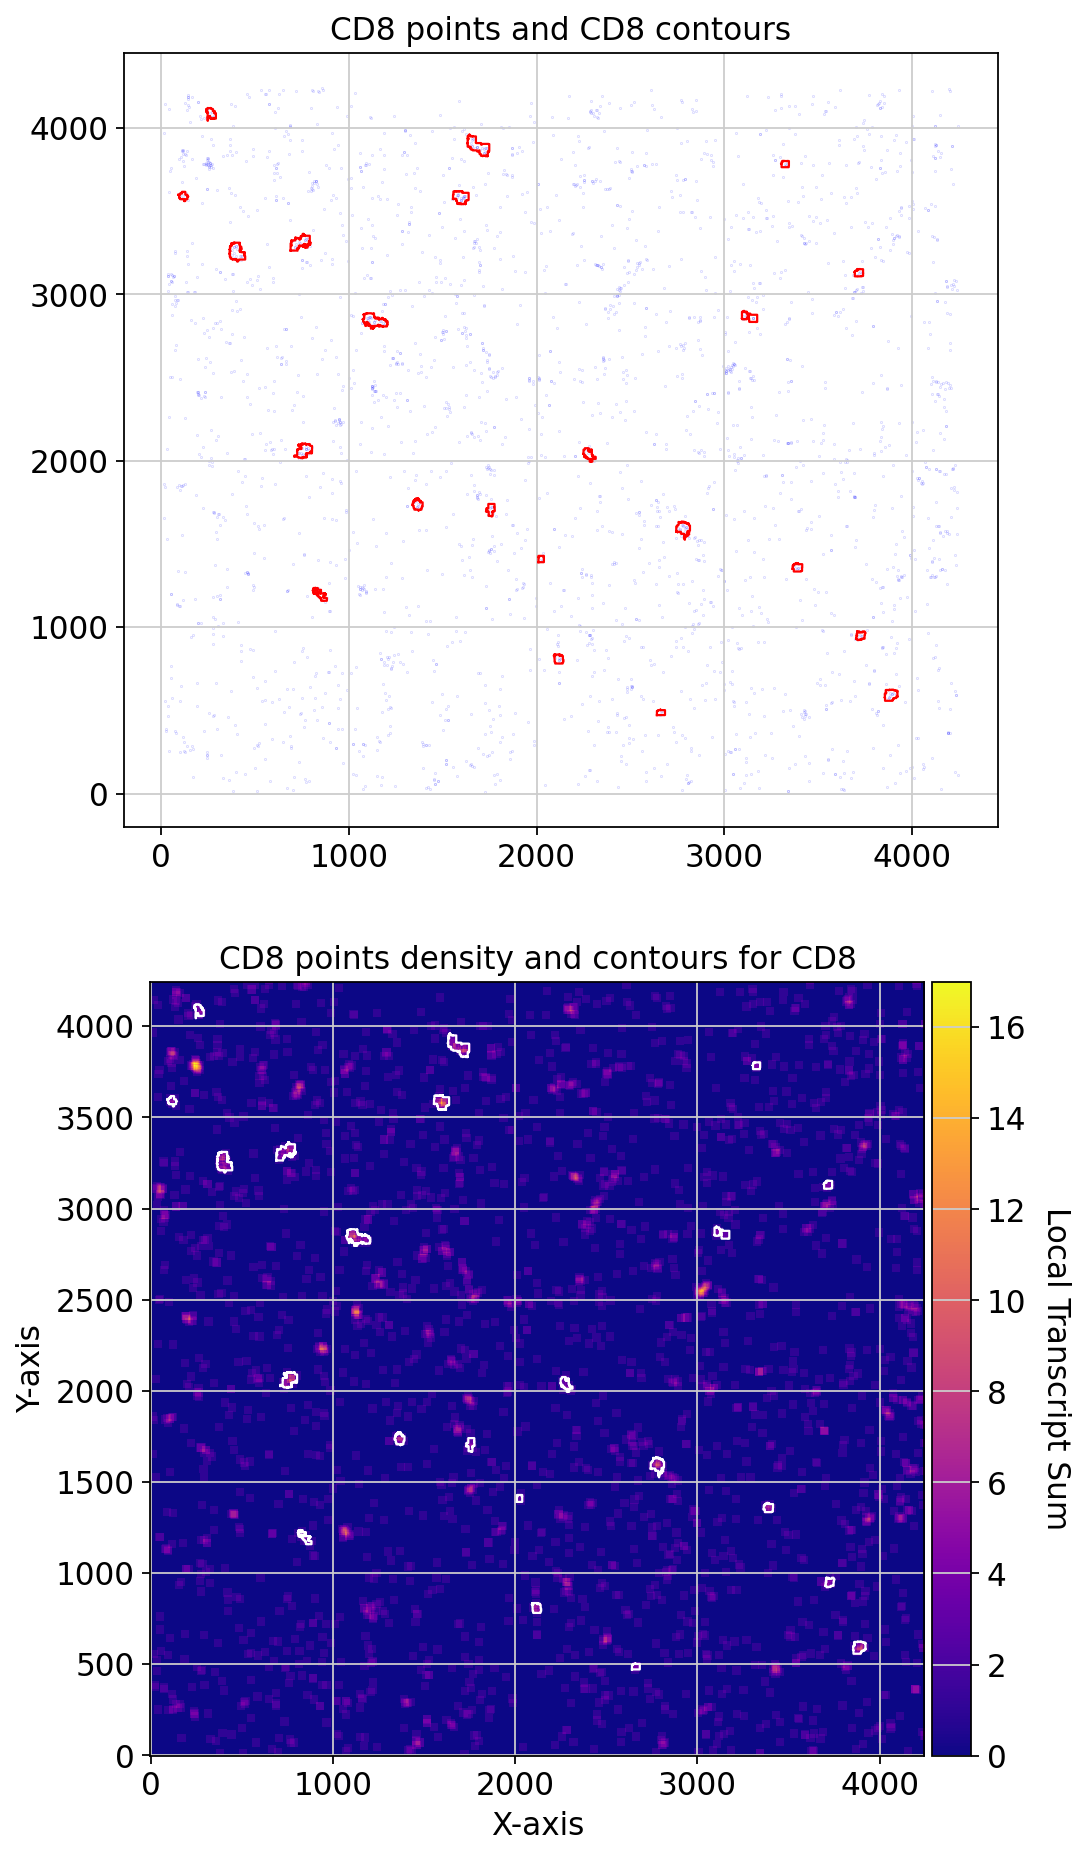

total contours found  22


In [41]:
CCD8 = contours.ConvolutionContours(array_subset_cd8, contour_name='CD8', logger=logger)
CCD8.get_conv_sum(kernel_size=kernel_size_cd8, kernel_shape='square')  

CCD8.contours_from_sum(density_threshold=density_th_cd8,
                      min_area_threshold=min_area_th_cd8, directionality='higher')

CCD8.filter_contours_by_gene_threshold(gene_array = np.sum(array_subset_cd8_gene, axis=-1).squeeze(), threshold = 1, gene_name = 'CD8')# >= 1
CCD8.filter_contours_by_gene_threshold(gene_array = array_subset_TRAC_gene.squeeze(), threshold = 1, gene_name = 'TRAC')# >= 1
CCD8.filter_contours_by_gene_threshold(gene_array = np.sum(array_subset_TRBC_gene, axis=-1), threshold = 1, gene_name = 'TRBC1_2')# >= 1

# gene_counts_ab > gene_counts_gd

CCD8.filter_contours_by_gene_comparison(gene_array1 = array_subset_ab, gene_array2 = array_subset_gd,
                                       gene_name1 = "ab", gene_name2 = "gd") # gene 1 > gene2 --> valid contour 


# CD8 > gene counts cd4 
CCD8.filter_contours_by_gene_comparison(gene_array1 = array_subset_cd8_gene, gene_array2 = array_subset_cd4_gene,
                                       gene_name1 = "CD8", gene_name2 = "CD4") # gene 1 > gene2 --> valid contour
print('total contours found ', len(CCD8.contours))

fig, axs = plt.subplots(2, 1, figsize=(7, 14))

CCD8.plot_contours_scatter(path=None, show=False, s=0.05, alpha=0.5, linewidth=1,
                              c_points='blue', c_contours='red', ax=axs[0])
axs[0].set_title('CD8 points and CD8 contours')

CCD8.plot_conv_sum(cmap='plasma', c_countour='white', path=None, ax=axs[1])
axs[1].set_title('CD8 points density and contours for CD8')

plt.show()

print('total contours found ', len(CCD8.contours))

***Multi class object***

We have now CD8 and γδ contours, we will use the multiclass object analysis to derive the masks and their expansions without overlapping. 

For this, MultiClassObjectAnalysis, uses the given contours and derive Voronoi polygons based on the centroids of the contours. The expansions, 10 , 20 and 30, are allowed fo reach contour only inside its Voronoi polygon. 

2025-06-16 16:32:13,042 - gridgen.get_masks.GetMasks - INFO - Initialized GetMasks


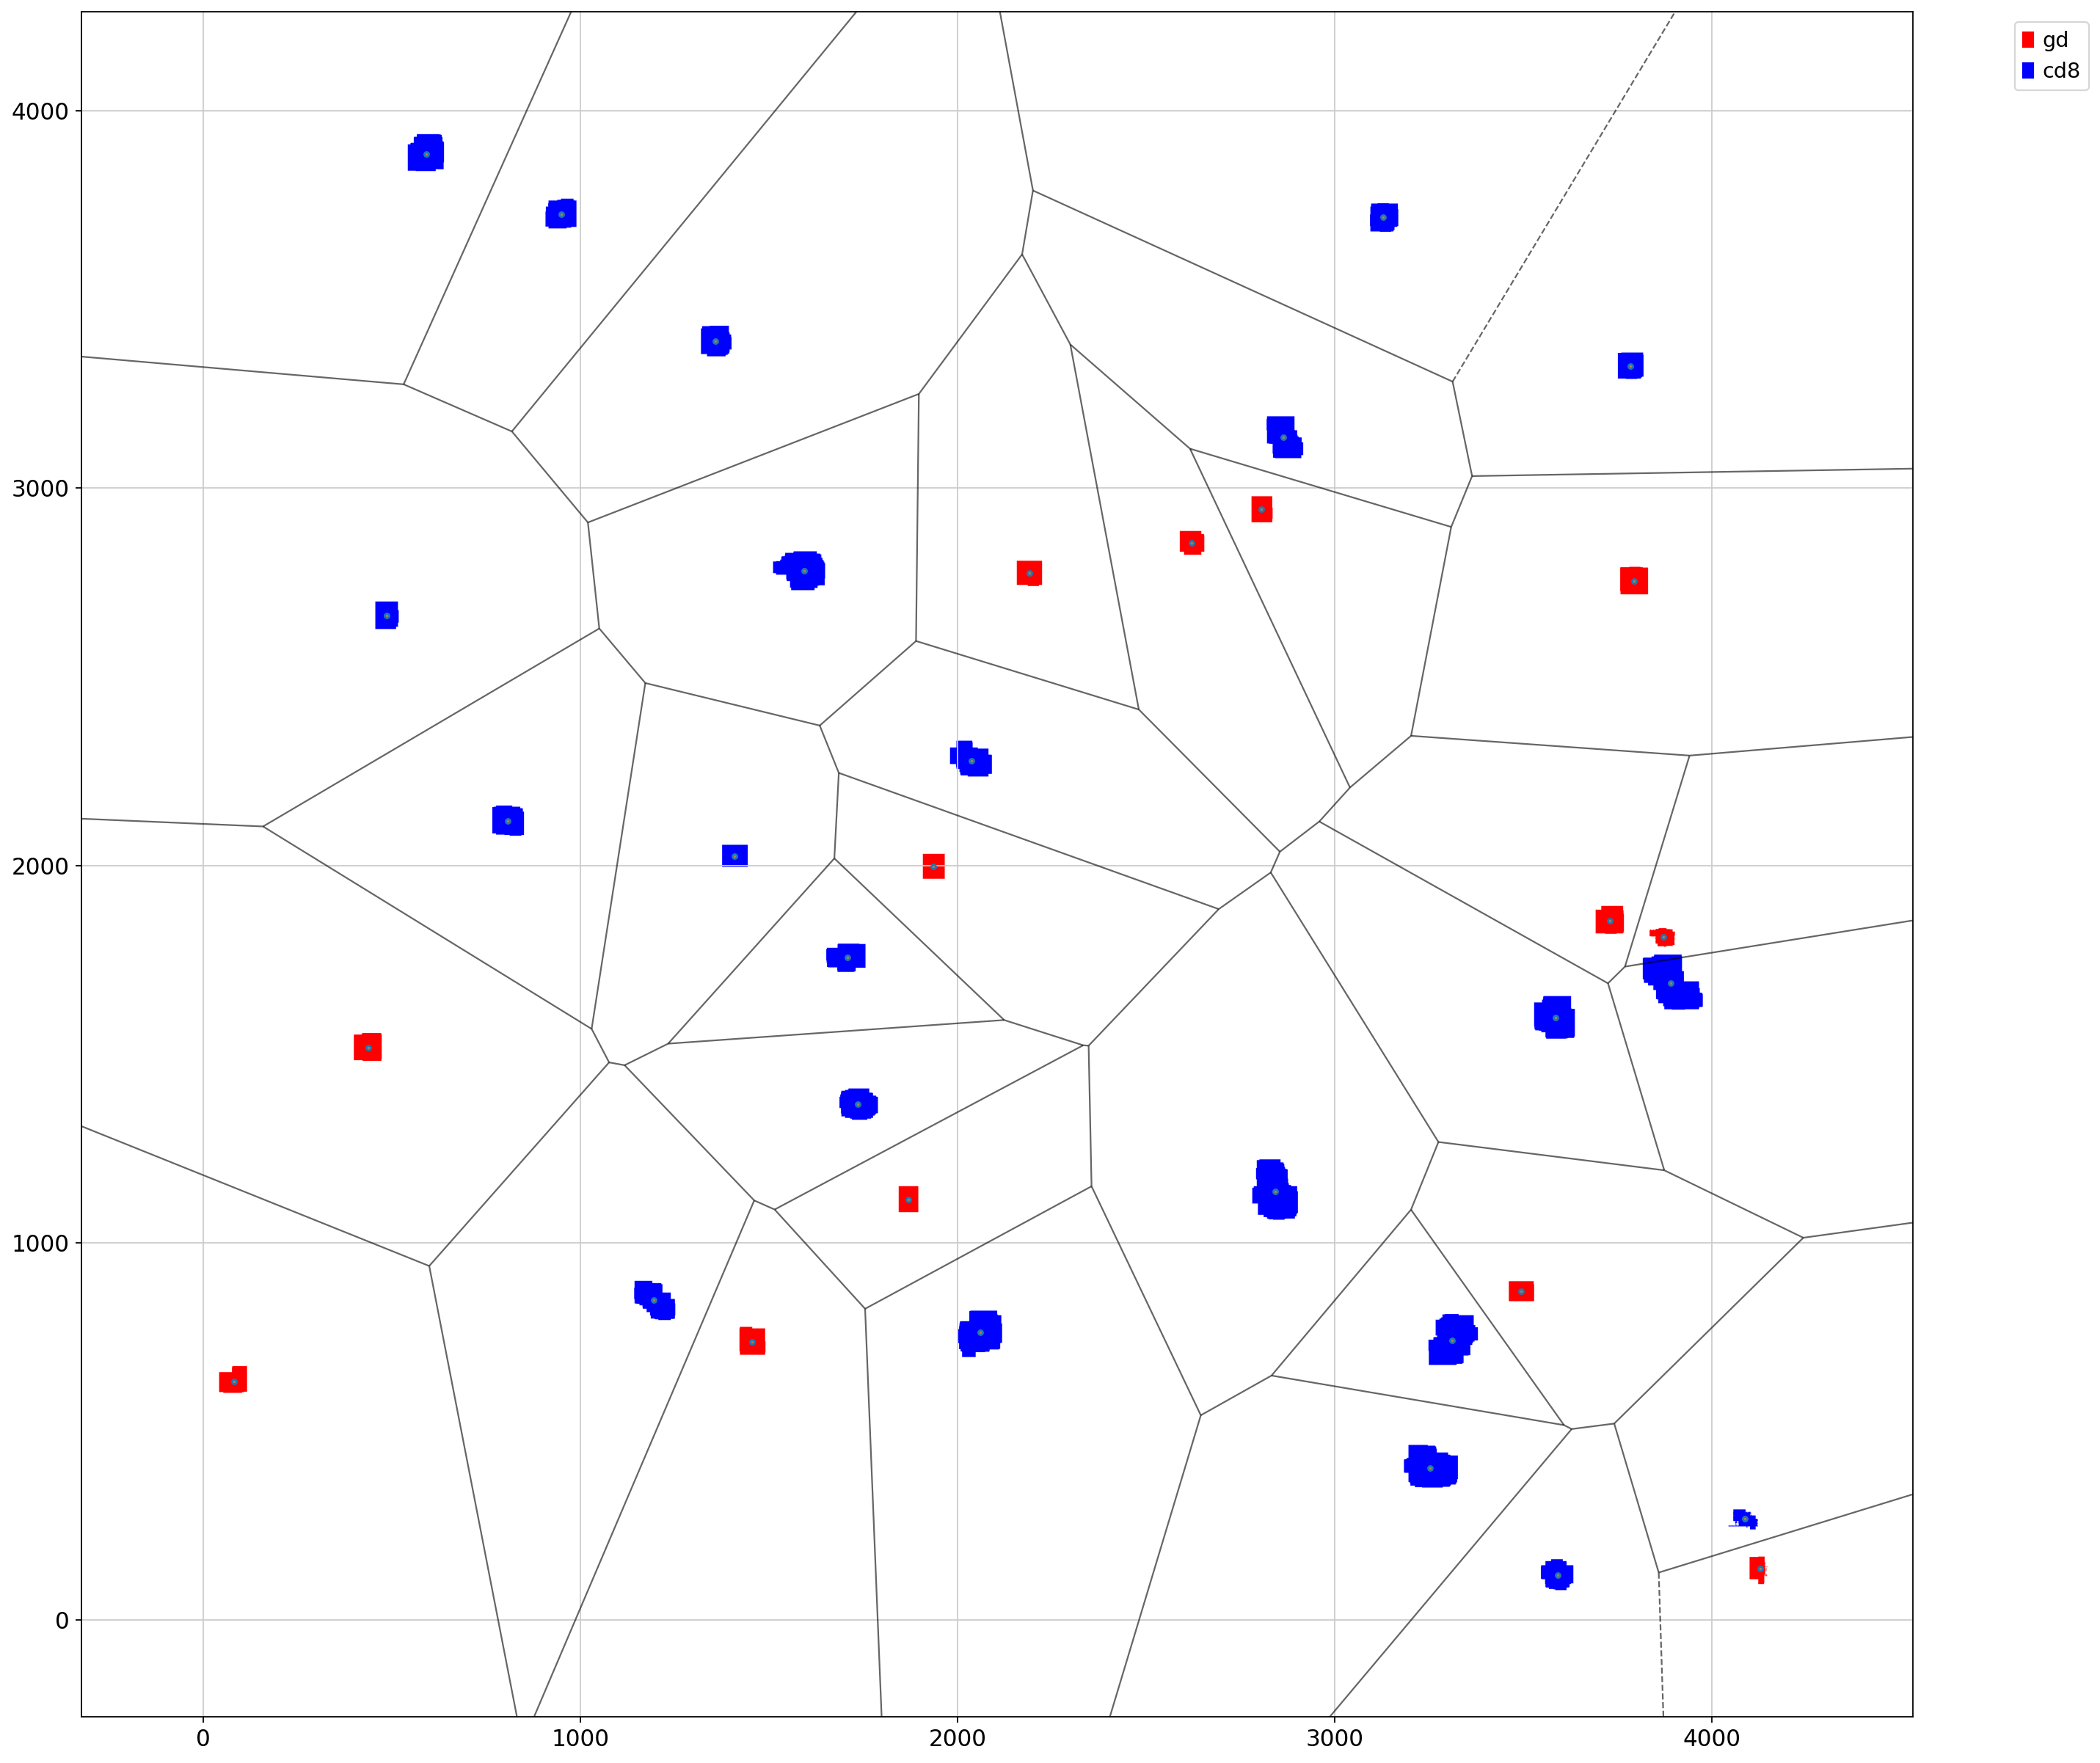

In [42]:
# Initialize base mask handler
GM = get_masks.GetMasks(image_shape=(height, width))

# Multiple contours per class
multiple_contours = {
    'gd': CGD.contours,
    'cd8': CCD8.contours
}

# Instantiate MultiClassObjectAnalysis
MCA = MultiClassObjectAnalysis(GM, multiple_contours=multiple_contours)

# Derive Voronoi polygons 
MCA.derive_voronoi_from_contours()

# Generate expanded masks limited by Voronoi partitions
binary_masks, label_mask, label_reference = MCA.generate_expanded_masks_limited_by_voronoi(expansion_distances=(30,))
# Define colors for plotting (used only for visualization)
mask_colors = {
    'gd': (255, 0, 0),
    'cd8': (0, 0, 255),
    # Optional: add more if multiple contours per class
}

# Plot with Voronoi edges and color-coded masks
MCA.plot_masks_with_voronoi(mask_colors=mask_colors, show=True, figsize=(20, 20))

***Explore full cohort***

In [43]:
# Custom logger setup - Will set to warning
logger = logging.getLogger('contour_logger')
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.WARNING)

save_path_ = 'results/multobj_cosmx2/'
if not os.path.exists(save_path_):
    os.makedirs(save_path_)
    
for file_csv in tqdm(files_cosmx, desc="Processing Folders", unit="folder"):
    start_time_lap = time.time()
    logger.info(f'Processing folder {file_csv}')
    base_name = os.path.basename(file_csv)

    fov_match = re.search(r'FOV\d+', file_csv)
    fov_part = fov_match.group()
    if fov_part == "FOV004":
        continue
    save_path = os.path.join(save_path_, fov_part)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    if os.path.exists(os.path.join(save_path + f'/{fov_part}_mob2.csv')):
        continue
        
    df_total = pd.read_csv(file_csv)
    df_total = df_total.rename(columns={'x': 'X', 'y': 'Y'})
    df_total = df_total[~df_total['target'].str.contains('System|egative')]
    
    n_genes = len(df_total['target'].unique())
    height = int(max(df_total['X'])) + 1
    width = int(max(df_total['Y'])) + 1
    
    # arrays
    target_dict_total = {target: index for index, target in enumerate(df_total['target'].unique())}
    array_total = ga.transform_df_to_array(df = df_total, target_dict=target_dict_total, array_shape = (height, width,len(target_dict_total))).astype(np.int8)
    
    df_subset_gd, array_subset_gd, target_indices_subset_gd = ga.get_subset_arrays(df_total, array_total,
                                                                                       target_dict_total,
                                                                                       target_list=target_gd,
                                                                               target_col='target')
    
    df_subset_ab, array_subset_ab, target_indices_subset_ab = ga.get_subset_arrays(df_total, array_total,
                                                                                           target_dict_total,
                                                                                           target_list=target_ab,
                                                                                           target_col='target')
        
        
    df_subset_g, array_subset_g, target_indices_subset_g = ga.get_subset_arrays(df_total, array_total,
                                                                                           target_dict_total,
                                                                                           target_list=['TRGC1/TRGC2'],
                                                                                           target_col='target')
        
    df_subset_d, array_subset_d, target_indices_subset_d = ga.get_subset_arrays(df_total, array_total,
                                                                                           target_dict_total,
                                                                                           target_list=['TRDC'],
                                                                                           target_col='target')
    
    
    df_subset_tum, array_subset_tum, target_indices_subset_tum = ga.get_subset_arrays(df_total, array_total,target_dict_total,
                                                                             target_list=target_tum, target_col = 'target')
    
    
    df_subset_cd8, array_subset_cd8, target_indices_subset_cd8 = ga.get_subset_arrays(df_total, array_total,
                                                                                          target_dict_total,
                                                                                          target_list=target_cd8,
                                                                                          target_col='target')
                                                                                   
    
    df_subset_TRAC_gene, array_subset_TRAC_gene, target_indices_subset_TRAC_gene = ga.get_subset_arrays(df_total, 
                                                                                                     array_total,
                                                                                          target_dict_total,
                                                                                          target_list= ['TRAC'],
                                                                                          target_col='target')
    
    df_subset_TRBC_gene, array_subset_TRBC_gene, target_indices_subset_TRBC_gene = ga.get_subset_arrays(df_total, 
                                                                                                     array_total,
                                                                                          target_dict_total,
                                                                                          target_list= ['TRBC1/TRBC2'],
                                                                                          target_col='target')
    
    
    df_subset_cd8_gene, array_subset_cd8_gene, target_indices_subset_cd8_gene = ga.get_subset_arrays(df_total, 
                                                                                                     array_total,
                                                                                          target_dict_total,
                                                                                          target_list= ['CD8A', 'CD8B'],
                                                                                          target_col='target')
    
    df_subset_cd4_gene, array_subset_cd4_gene, target_indices_subset_cd4_gene = ga.get_subset_arrays(df_total, 
                                                                                                     array_total,
                                                                                          target_dict_total,
                                                                                          target_list= ['CD4'],
                                                                                          target_col='target')
    
    CGD = contours.ConvolutionContours(array_subset_gd, contour_name='GD', logger=logger)
    CGD.get_conv_sum(kernel_size=kernel_size_gd, kernel_shape='square')  #
    CGD.contours_from_sum(density_threshold=density_th_gd,
                          min_area_threshold=min_area_th_gd, directionality='higher')
    
    ### Filtering 
    CGD.filter_contours_by_gene_comparison(gene_array1 = array_subset_gd, gene_array2 = array_subset_ab,
                                           gene_name1 = "gd", gene_name2 = "ab") # gene 1 > gene2 --> valid contour 
    # G>0 D>0
    CGD.filter_contours_by_gene_threshold(gene_array = array_subset_d.squeeze(), threshold = 1, gene_name = 'TRDC')# >= 1
    CGD.filter_contours_by_gene_threshold(gene_array = np.sum(array_subset_g, axis=-1), threshold = 1, gene_name = 'TRGC1_2')# >= 1
    
    # CD8
    CCD8 = contours.ConvolutionContours(array_subset_cd8, contour_name='CD8', logger=logger)
    CCD8.get_conv_sum(kernel_size=kernel_size_cd8, kernel_shape='square')  
    
    CCD8.contours_from_sum(density_threshold=density_th_cd8,
                          min_area_threshold=min_area_th_cd8, directionality='higher')
    
    CCD8.filter_contours_by_gene_threshold(gene_array = np.sum(array_subset_cd8_gene, axis=-1).squeeze(), threshold = 1, gene_name = 'CD8')# >= 1
    CCD8.filter_contours_by_gene_threshold(gene_array = array_subset_TRAC_gene.squeeze(), threshold = 1, gene_name = 'TRAC')# >= 1
    CCD8.filter_contours_by_gene_threshold(gene_array = np.sum(array_subset_TRBC_gene, axis=-1), threshold = 1, gene_name = 'TRBC1_2')# >= 1
    
    # gene_counts_ab > gene_counts_gd
    
    CCD8.filter_contours_by_gene_comparison(gene_array1 = array_subset_ab, gene_array2 = array_subset_gd,
                                           gene_name1 = "ab", gene_name2 = "gd") # gene 1 > gene2 --> valid contour 
    
    
    # CD8 > gene counts cd4 
    CCD8.filter_contours_by_gene_comparison(gene_array1 = array_subset_cd8_gene, gene_array2 = array_subset_cd4_gene,
                                           gene_name1 = "CD8", gene_name2 = "CD4") # gene 1 > gene2 --> valid contour

    for var_name in list(globals().keys()):
        if (
            (var_name.startswith('df_') or var_name.startswith('array_'))
            and var_name != 'array_total'
        ):
            del globals()[var_name]

    GM = get_masks.GetMasks(image_shape=(height, width))
    
    multiple_contours = {'gd': CGD.contours,
                        'cd8': CCD8.contours}
    MCA = MultiClassObjectAnalysis(GM, multiple_contours) 
    
    MCA.derive_voronoi_from_contours()
    masks_MCA = MCA.generate_expanded_masks_limited_by_voronoi(expansion_distances=(20,))
    mask_definitions = [
        MaskDefinition(mask=MCA.binary_masks['gd'], mask_name='gd', analysis_type='per_object'),
        MaskDefinition(mask=MCA.binary_masks['gd_expansion_20'], mask_name='gd_expansion_20', analysis_type='per_object'),
        MaskDefinition(mask=MCA.binary_masks['cd8'], mask_name='cd8', analysis_type='per_object'),
        MaskDefinition(mask=MCA.binary_masks['cd8_expansion_20'], mask_name='cd8_expansion_20', analysis_type='per_object'),
]

    # 2. Initialize and run the analysis pipeline
    pipeline = MaskAnalysisPipeline(mask_definitions=mask_definitions, 
                                    array_counts = array_total,
                            target_dict = target_dict_total,
      )
    results = pipeline.run()
    df = pipeline.get_results_df()
    df.to_csv(os.path.join(save_path + f'/{fov_part}_mob2.csv'), index=False)
    del array_total
    gc.collect()

Processing Folders: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 75234.15folder/s]


***analysis of results***

In [18]:
save_path_ = 'results/multobj_cosmx/'

dfs = []
for file_csv in files_cosmx: 
    fov_match = re.search(r'FOV\d+', file_csv)
    fov_part = fov_match.group()
    if fov_part in ['FOV004', 'FOV020', ]: # 'FOV018','FOV019'
        continue
    base_name = os.path.basename(file_csv)

    df = pd.read_csv(os.path.join(os.path.join(save_path_, fov_part) + f'/{fov_part}_mob.csv'))
    df['selection'] = fov_part
    dfs.append(df)

full_df = pd.concat(dfs, ignore_index=True)
full_df

full_df['mask_name'].value_counts()
full_df.head()

,mask_name,object_id,area,perimeter,centroid,min_x,min_y,max_x,max_y,vertices,...,NRXN1,CCL26,RSPO3,CYP2U1,FZD7,TTR,RPS4Y1,LGR5,per_object,selection
0,cd8,1,6624.0,579.906638,"(np.float64(52.421195652173914), np.float64(55...",495,7,603,109,6624,...,0,0,0,0,0,0,0,0,True,FOV001
1,cd8_expansion_20,1,4842.0,1087.753355,"(np.float64(57.93411813300289), np.float64(557...",486,0,613,119,4842,...,0,0,0,0,0,0,0,0,True,FOV001
2,gd,1,1290.0,142.000000,"(np.float64(183.5), np.float64(80.0))",59,169,102,199,1290,...,0,0,0,0,0,0,0,0,True,FOV001
3,gd_expansion_20,1,1748.0,365.656854,"(np.float64(184.36899313501144), np.float64(80...",50,160,112,209,1748,...,0,0,0,0,0,0,0,0,True,FOV001
4,cd8,2,3826.0,368.509668,"(np.float64(43.46602195504443), np.float64(248...",2448,8,2541,81,3826,...,0,1,0,0,0,0,0,0,True,FOV001


Transform into adata object

In [20]:
obs_columns = ['area', 'perimeter', 'centroid', 'min_x', 'min_y', 'max_x', 'max_y', 'vertices', 
               'BoundingBox', 'mask_name', 'per_object', 'selection', 'object_id']
counts_columns = full_df.columns.difference(obs_columns)
counts = full_df[counts_columns]

obs = full_df[obs_columns]


adata = ad.AnnData(counts)
adata.obs = obs
adata.layers["counts"] = adata.X.copy()
adata.obs.head()

/home/martinha/miniconda3/envs/GRIDGEN/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


,area,perimeter,centroid,min_x,min_y,max_x,max_y,vertices,BoundingBox,mask_name,per_object,selection,object_id
0,6624.0,579.906638,"(np.float64(52.421195652173914), np.float64(55...",495,7,603,109,6624,"[(7, 495, 109, 603)]",cd8,True,FOV001,1
1,4842.0,1087.753355,"(np.float64(57.93411813300289), np.float64(557...",486,0,613,119,4842,"[(0, 486, 119, 613)]",cd8_expansion_20,True,FOV001,1
2,1290.0,142.000000,"(np.float64(183.5), np.float64(80.0))",59,169,102,199,1290,"[(169, 59, 199, 102)]",gd,True,FOV001,1
3,1748.0,365.656854,"(np.float64(184.36899313501144), np.float64(80...",50,160,112,209,1748,"[(160, 50, 209, 112)]",gd_expansion_20,True,FOV001,1
4,3826.0,368.509668,"(np.float64(43.46602195504443), np.float64(248...",2448,8,2541,81,3826,"[(8, 2448, 81, 2541)]",cd8,True,FOV001,2


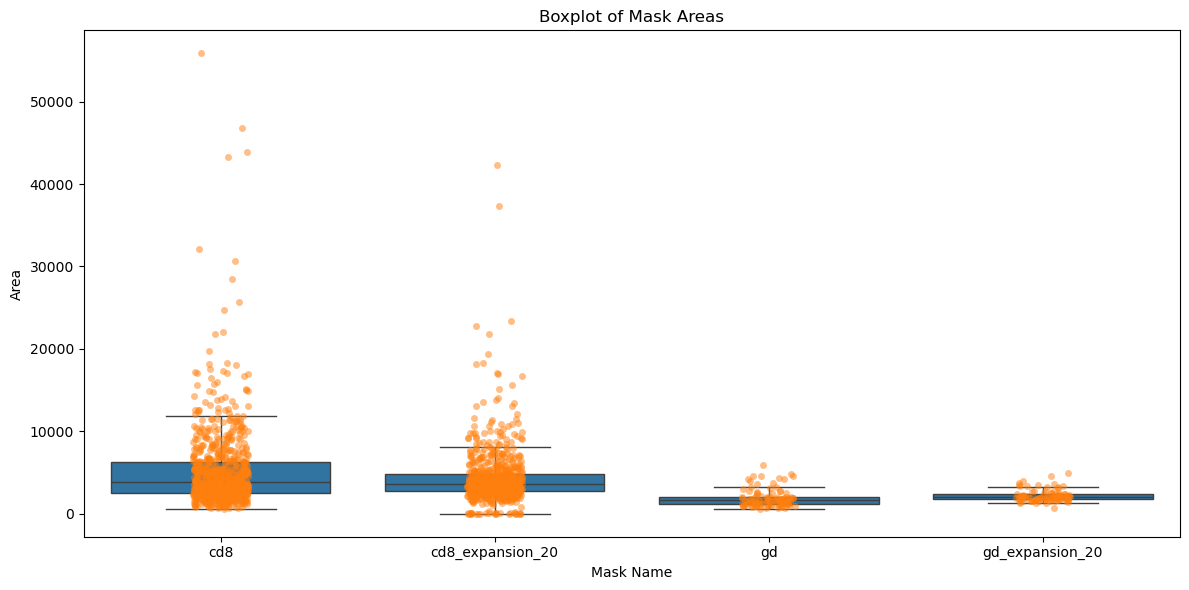

In [26]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='mask_name', y='area', data=adata.obs, showfliers=False)

# Overlay the points
sns.stripplot(x='mask_name', y='area', data=adata.obs, alpha=0.5)

plt.title('Boxplot of Mask Areas')
plt.xlabel('Mask Name')
plt.ylabel('Area')
plt.tight_layout()
plt.show()

Normalization

We will normalize the values, as it was single cell data

/home/martinha/miniconda3/envs/GRIDGEN/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:243: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


Elbow at:  13


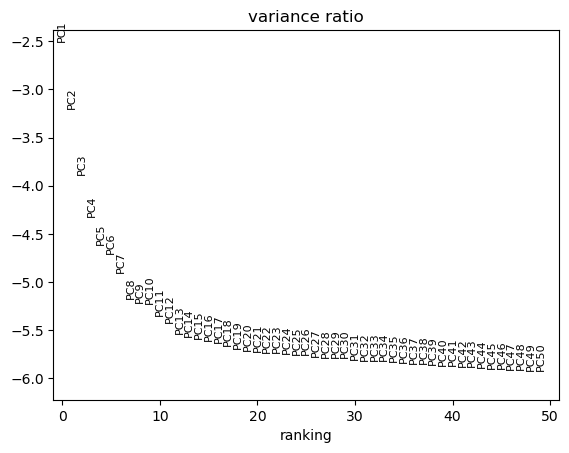

/home/martinha/miniconda3/envs/GRIDGEN/lib/python3.11/site-packages/anndata/_core/anndata.py:1138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
/home/martinha/miniconda3/envs/GRIDGEN/lib/python3.11/site-packages/anndata/_core/anndata.py:1138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c


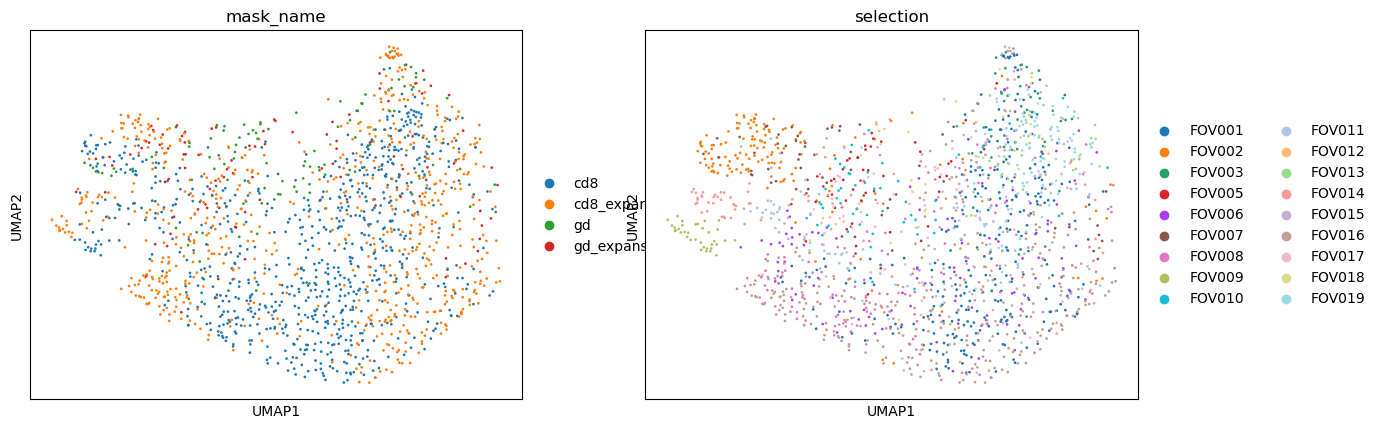

In [28]:
# Normalize the counts in the 'X' matrix
adata.X = np.nan_to_num(adata.X / adata.obs['area'].values[:, None])*100
# sc.pp.scale(adata)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.tl.pca(adata)
pct = adata.uns['pca']['variance_ratio'] / sum(adata.uns['pca']['variance_ratio']) * 100
cumu = np.cumsum(pct)
# Point 1.
co1 = list(np.where(np.logical_and(cumu > 90, pct < 5))[0])[0]
# Point 2.
x = list(np.where(pct[0:len(pct)-1] - pct[1:len(pct)] > 0.1)[0])
x.sort(reverse=True)
co2 = x[0]+1
# Elbow:
elbow = min(co1, co2) + 1 # Without the +1, it gives the index and not the PC number
                          # (indices in python start with 0, unlike R that start with 1)
print('Elbow at: ', elbow)

sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

sc.pp.neighbors(adata, n_neighbors=20) #, n_pcs=elbow)

sc.tl.umap(adata) 

sc.pl.umap(
    adata,
    color= ["mask_name", "selection"],
    size=15,
)

In [30]:
adata.obs['mask_name'] = adata.obs['mask_name'].replace({
    'cd8_expansion_20': 'CD8 20μm',
    'gd_expansion_20': 'γδ 20μm'
})

/tmp/ipykernel_2795906/1613035753.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs['mask_name'] = adata.obs['mask_name'].replace({
/tmp/ipykernel_2795906/1613035753.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['mask_name'] = adata.obs['mask_name'].replace({


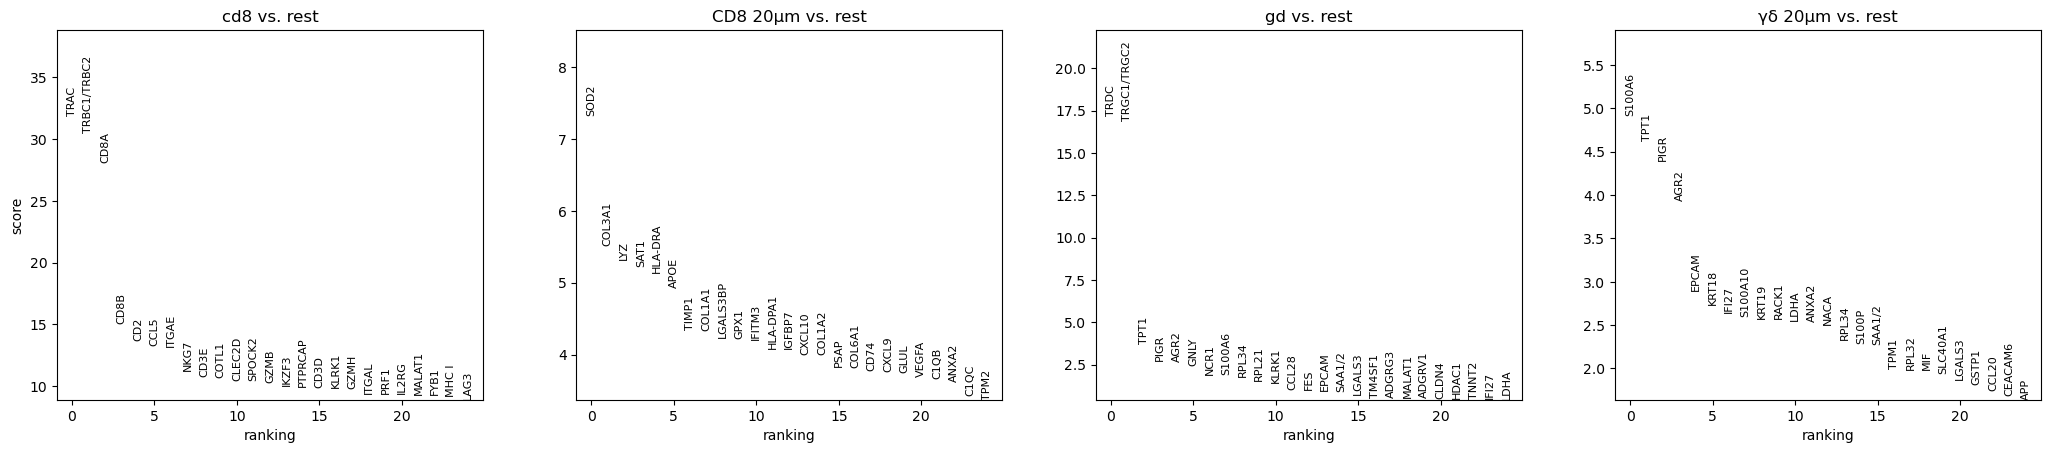

In [32]:
sc.tl.rank_genes_groups(adata, "mask_name", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

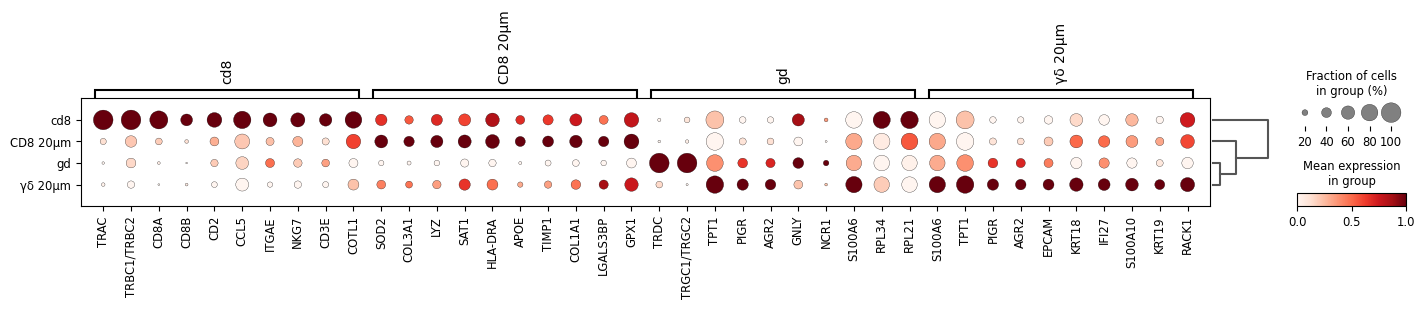

In [33]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="mask_name", standard_scale="var", n_genes=10)

Just the expansions

/home/martinha/miniconda3/envs/GRIDGEN/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:669: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/home/martinha/miniconda3/envs/GRIDGEN/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


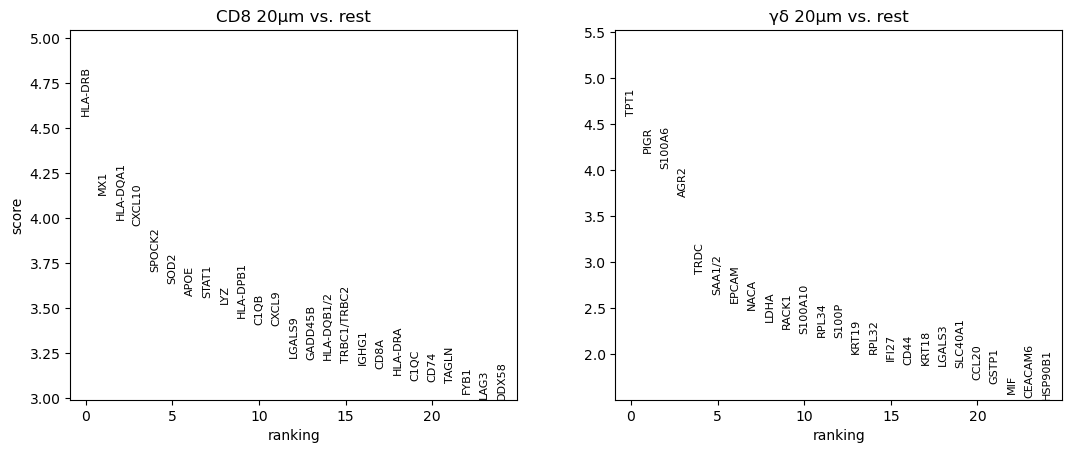

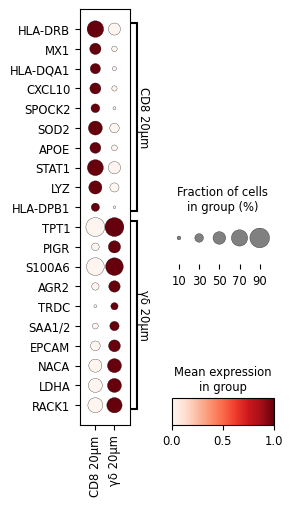

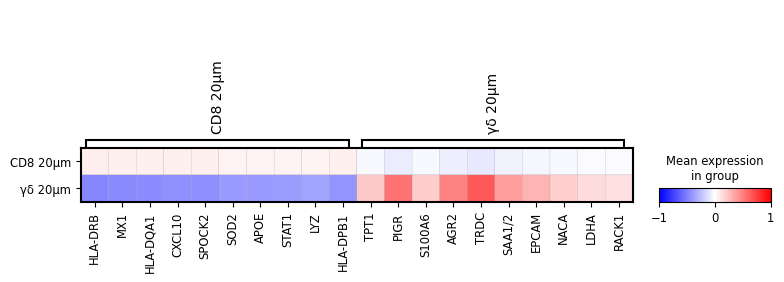

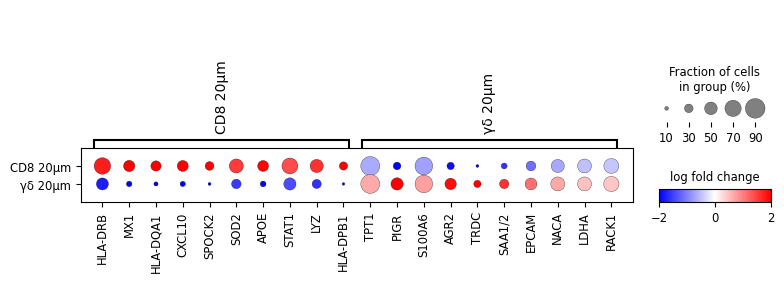

In [36]:
cl1 = adata[adata.obs['mask_name'].isin(['CD8 20μm','γδ 20μm'])]

sc.tl.rank_genes_groups(cl1, "mask_name", method="wilcoxon")

sc.pl.rank_genes_groups(cl1, n_genes=25, sharey=False)
sc.tl.dendrogram(cl1,"mask_name")
sc.pl.rank_genes_groups_dotplot(
    cl1, groupby="mask_name", standard_scale="var",
    figsize=(2.5,5),
    n_genes=10,swap_axes = True, save='dotplot_logfoldchanges_exp.png')

cl1.layers["scaled"] = sc.pp.scale(cl1, copy=True).X
sc.pl.rank_genes_groups_matrixplot(
    cl1, n_genes=10, use_raw=False, vmin=-1, vmax=1, cmap="bwr", layer="scaled"
)

sc.pl.rank_genes_groups_dotplot(
    cl1,
    n_genes=10,
    values_to_plot="logfoldchanges",
    min_logfoldchange=0.1,  # with 1 log fold change GD 10 does not have any 
    vmax=2,
    vmin=-2,
    cmap="bwr",
    save='dotplot_logfoldchanges_all.png'

)


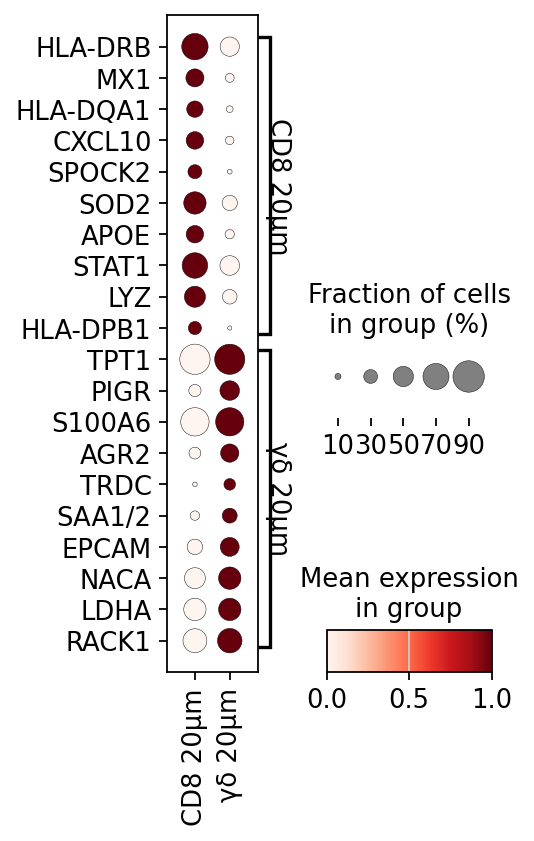

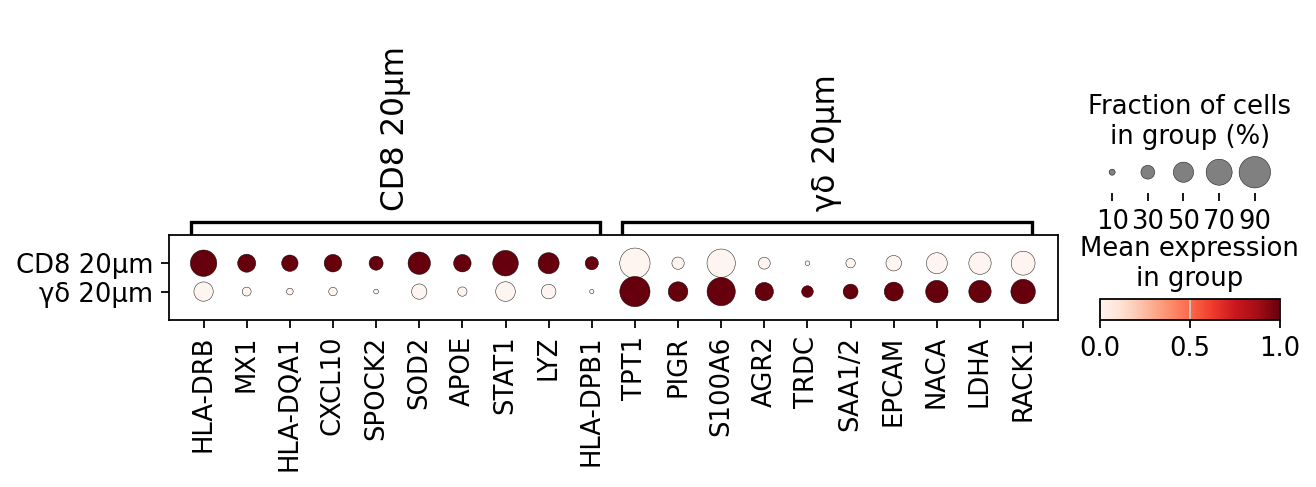

In [37]:
sc.set_figure_params(dpi_save=500,vector_friendly=True, fontsize=14, figsize=None)
sc.pl.rank_genes_groups_dotplot(
    cl1, groupby="mask_name", standard_scale="var",
    n_genes=10,swap_axes = True,  
    figsize = (2.6,5),
 save='dotplot_logfoldchanges_exp3.png')


sc.pl.rank_genes_groups_dotplot(
    cl1, groupby="mask_name", standard_scale="var",
    n_genes=10,swap_axes = False,  
 save='dotplot_logfoldchanges_exp.png')